In [47]:
import pandas as pd
import mne


Paper uses "Version that was downsampled to 128 Hz and filtered by a band-pass filter with cut-off frequencies of 4 and 45"\
Using pruned dataset having ICA done with filter of 0.5-40 Hz sampled at 128Hz

In [76]:
df=pd.read_csv("/Users/harsh_dadwal/Harsh/coding/ml/music_eeg/Emotions_Train.csv")
train_df=df[["id","label"]]
train_df

,id,label
0,3784258358,0
1,2395445698,2
2,3049220457,3
3,2667905835,3
4,1281311748,0
...,...,...
218,7081425536,1
219,5527955318,1
220,1424199427,0
221,3966019638,3


In [77]:
id=train_df['id'][0]
raw = mne.io.read_raw_fif(f'/Users/harsh_dadwal/Harsh/coding/ml/music_eeg/Dataset/eremus_dataset/pruned/train/{id}_eeg.fif',preload=True)
raw

Opening raw data file /Users/harsh_dadwal/Harsh/coding/ml/music_eeg/Dataset/eremus_dataset/pruned/train/3784258358_eeg.fif...
    Range : 9361 ... 19600 =     73.133 ...   153.125 secs
Ready.
Reading 0 ... 10239  =      0.000 ...    79.992 secs...


<Raw | 3784258358_eeg.fif, 32 x 10240 (80.0 s), ~2.5 MB, data loaded>

filtered_data has the time series frequency component feature and each key i.e freq_band will house data of size 32x10240 (channel x timepoints)

In [78]:
from scipy.signal import butter, sosfilt

frequency_bands = {
    'Theta': (4, 8),
    'Alpha': (8, 14),
    'Beta': (14, 31),
    'Gamma': (31, 50)
}
filter_order = 30  # High order for sharper transitions

# Function to apply band-pass filter for each frequency band
def apply_bandpass_filter(data, lowcut, highcut, fs, order=filter_order):
    sos = butter(order, [lowcut, highcut], btype='band', fs=fs, output='sos')
    return sosfilt(sos, data)

# Apply filters to each band
filtered_data = {}
for band, (lowcut, highcut) in frequency_bands.items():
    filtered_data[band] = apply_bandpass_filter(raw.get_data(), lowcut, highcut, fs=raw.info['sfreq'])

In [79]:
print(raw.get_data().shape)
raw.info['sfreq']

(32, 10240)


128.0

In [80]:
import numpy as np

# Define feature extraction functions
def extract_features(segment):
    """Extracts time-domain features for a given EEG segment."""
    mean = np.mean(segment, axis=1)
    variance = np.var(segment, axis=1)
    std_dev = np.std(segment, axis=1)
    mean_diff1 = np.mean(np.diff(segment, n=1, axis=1), axis=1)
    mean_diff2 = np.mean(np.diff(segment, n=2, axis=1), axis=1)
    entropy = -np.sum(segment * np.log(np.abs(segment) + 1e-10), axis=1)  # Simple entropy measure
    return np.stack([mean, variance, std_dev, mean_diff1, mean_diff2, entropy], axis=1)

In [81]:
# Parameters
segment_length = 1280  # Length of each segment, e.g., 1 second at 128 Hz
n_channels = filtered_data['Theta'].shape[0]  # Assuming 32 channels

# Initialize a dictionary to store features for each frequency band
features_by_band = {}

for band, data in filtered_data.items():
    n_samples = data.shape[1]
    n_segments = n_samples // segment_length  # Number of segments per trial
    
    # Segment the data and extract features
    features = []
    for i in range(n_segments):
        segment = data[:, i*segment_length : (i+1)*segment_length]  # Non-overlapping segment
        band_features = extract_features(segment)  # Shape: (n_channels, n_features)
        features.append(band_features)
        
    # Stack features across all segments for the current band
    features_by_band[band] = np.stack(features, axis=0)  # Shape: (n_segments, n_channels, n_features)

We have a 3d matrix in which we have a time feature for each channel of each segment

In [82]:
print(f'{n_segments}')
print(features_by_band['Theta'].shape)
print(features_by_band['Alpha'].shape)
print(features_by_band['Beta'].shape)
print(features_by_band['Gamma'].shape)

8
(8, 32, 6)
(8, 32, 6)
(8, 32, 6)
(8, 32, 6)


In [83]:
channel_order = raw.ch_names
print(channel_order)  # Lists channels in order as they appear in the array

['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']


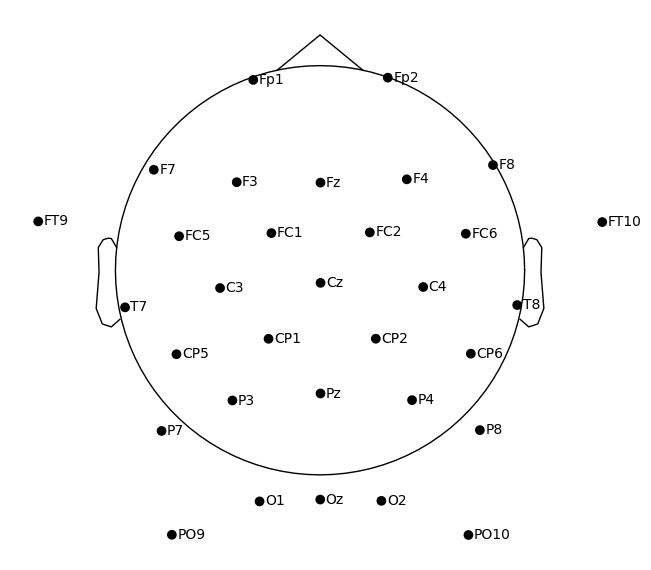

In [84]:
if not raw.info['chs'][0]['loc'].any():
    # If not, set a standard montage (e.g., 10-20 system)
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage)

# Plot the sensor locations on a 3D head model
fig = raw.plot_sensors(kind='topomap', show_names=True)

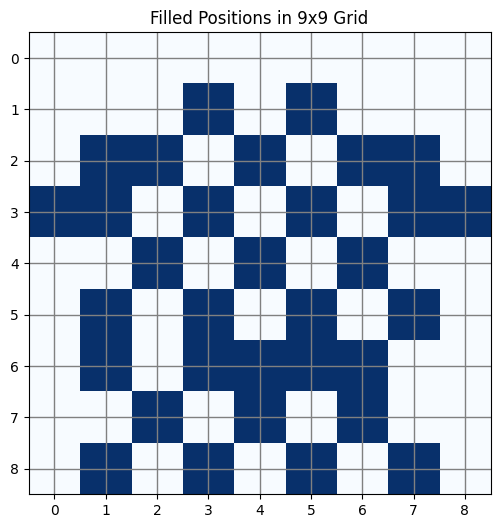

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Define the size of the grid
grid_size = 9

# Define the (row, col) positions in a 9x9 grid for each of the 32 EEG channels.
electrode_positions = [
    (4, 4),  # Cz (center)
    (2, 4),  # Fz
    (1, 3),  # Fp1
    (2, 1),  # F7
    (2, 2),  # F3
    (3, 3),  # FC1
    (4, 2),  # C3
    (3, 1),  # FC5
    (3, 0),  # FT9
    (5, 1),  # T7
    (6, 1),  # CP5
    (5, 3),  # CP1
    (6, 3),  # P3
    (7, 2),  # P7
    (8, 1),  # PO9
    (8, 3),  # O1
    (6, 4),  # Pz
    (7, 4),  # Oz
    (8, 5),  # O2
    (8, 7),  # PO10
    (7, 6),  # P8
    (6, 5),  # P4
    (5, 5),  # CP2
    (6, 6),  # CP6
    (5, 7),  # T8
    (3, 8),  # FT10
    (3, 7),  # FC6
    (4, 6),  # C4
    (3, 5),  # FC2
    (2, 6),  # F4
    (2, 7),  # F8
    (1, 5),  # Fp2
]
# Initialize a 9x9 grid with all zeros
grid = np.zeros((grid_size, grid_size))

# Mark filled positions with a value of 1
for pos in electrode_positions:
    grid[pos] = 1

# Plot the grid
plt.figure(figsize=(6, 6))
plt.imshow(grid, cmap="Blues", origin='upper')

# Customize the plot
plt.title("Filled Positions in 9x9 Grid")
plt.xticks(range(grid_size))
plt.yticks(range(grid_size))
plt.grid(which='both', color='gray', linestyle='-', linewidth=1)
plt.show()

In [86]:
def create_spatial_matrix(feature_data, n_channels=32, grid_size=(9, 9)):
    """Maps the features into a 2D grid layout based on the EEG electrode arrangement."""
    spatial_matrix = np.zeros(grid_size + (feature_data.shape[1],))  # (9, 9, n_features)
    
    for idx, pos in enumerate(electrode_positions):
        spatial_matrix[pos[0], pos[1], :] = feature_data[idx, :]  # Assign features at each electrode position
    
    return spatial_matrix

# Combine features from all bands into a single 18x18 matrix 
dataset = []
for i in range(n_segments):
    # Initialize a 18x18x6 matrix
    combined_features = np.zeros((18, 18, 6))

    # Create the spatial matrix for each frequency band
    theta_matrix = create_spatial_matrix(features_by_band['Theta'][i], n_channels=32)
    alpha_matrix = create_spatial_matrix(features_by_band['Alpha'][i], n_channels=32)
    beta_matrix = create_spatial_matrix(features_by_band['Beta'][i], n_channels=32)
    gamma_matrix = create_spatial_matrix(features_by_band['Gamma'][i], n_channels=32)
    
    # Place each 9x9 frequency matrix into the appropriate quadrant of the 18x18 matrix
    combined_features[0:9, 0:9, :] = theta_matrix  # Top-left quadrant
    combined_features[0:9, 9:18, :] = alpha_matrix  # Top-right quadrant
    combined_features[9:18, 0:9, :] = beta_matrix  # Bottom-left quadrant
    combined_features[9:18, 9:18, :] = gamma_matrix  # Bottom-right quadrant
    
    # Append the final 18x18x6 matrix for this segment
    dataset.append(combined_features)

# Convert to numpy array for training
dataset = np.array(dataset)  # Shape: (n_segments, 18, 18, 6)

In [87]:
dataset.shape

(8, 18, 18, 6)

In [88]:
import numpy as np
import plotly.graph_objects as go

# Sample data for demonstration (replace this with your actual 18x18x6 matrix)
data_matrix = dataset[0]

# Get the indices of the non-zero elements
x, y, z = np.nonzero(data_matrix)
values = data_matrix[x, y, z]  # Get the values of the non-zero elements

# Define colors based on values (optional customization)
colorscale = 'Viridis'  # You can try other colorscales like 'Cividis', 'Plasma', etc.

# Create a 3D scatter plot of the non-zero elements
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=5,
        color=values,           # Color by value
        colorscale=colorscale,   # Choose colorscale
        colorbar=dict(title="Value"),  # Add a color bar
        opacity=0.8
    )
)])

# Set the layout for better visualization
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        xaxis=dict(nticks=18, range=[0, 18]),
        yaxis=dict(nticks=18, range=[0, 18]),
        zaxis=dict(nticks=6, range=[0, 6]),
    ),
    title="3D Visualization of Non-Zero Elements in 18x18x6 Matrix",
    margin=dict(l=0, r=0, b=0, t=30)
)

# Show the plot
fig.show()

Individual input seems to be in the right orientation

Get the output labels and the training matrices for all the training data

In [66]:
train_df

,id,label
0,3784258358,0
1,2395445698,2
2,3049220457,3
3,2667905835,3
4,1281311748,0
...,...,...
218,7081425536,1
219,5527955318,1
220,1424199427,0
221,3966019638,3


Function to preprocess each id and return a list of (segment_matrix,label) tuples

In [89]:
# Preprocessing function for each EEG signal ID
def preprocess_id(id, label, segment_length=1280):
    # Load EEG data
    raw = mne.io.read_raw_fif(f'/Users/harsh_dadwal/Harsh/coding/ml/music_eeg/Dataset/eremus_dataset/pruned/train/{id}_eeg.fif', preload=True)
    
    # Apply bandpass filtering for each frequency band
    filtered_data = {}
    for band, (lowcut, highcut) in frequency_bands.items():
        filtered_data[band] = apply_bandpass_filter(raw.get_data(), lowcut, highcut, fs=raw.info['sfreq'])
    
    # Extract features and map to 18x18x6 matrix
    segment_data = []
    for band, data in filtered_data.items():
        n_samples = data.shape[1]
        n_segments = n_samples // segment_length
        for i in range(n_segments):
            segment = data[:, i * segment_length : (i + 1) * segment_length]
            band_features = extract_features(segment)
            spatial_matrix = create_spatial_matrix(band_features)
            segment_data.append(spatial_matrix)
    
    # Combine matrices for each band into a final 18x18x6 matrix
    combined_features = []
    for segment in segment_data:
        combined_matrix = np.zeros((18, 18, 6))
        combined_matrix[0:9, 0:9, :] = segment  # Theta in top-left
        combined_matrix[0:9, 9:18, :] = segment  # Alpha in top-right
        combined_matrix[9:18, 0:9, :] = segment  # Beta in bottom-left
        combined_matrix[9:18, 9:18, :] = segment  # Gamma in bottom-right
        combined_features.append((combined_matrix, label))
    
    return combined_features


In [90]:
segment_dataset = []
for idx, row in train_df.iterrows():
    id, label = row['id'], row['label']
    segment_data = preprocess_id(id, label)
    segment_dataset.extend(segment_data)
segment_df = pd.DataFrame(segment_dataset, columns=['input_matrix', 'label'])
segment_df

Opening raw data file /Users/harsh_dadwal/Harsh/coding/ml/music_eeg/Dataset/eremus_dataset/pruned/train/3784258358_eeg.fif...
    Range : 9361 ... 19600 =     73.133 ...   153.125 secs
Ready.
Reading 0 ... 10239  =      0.000 ...    79.992 secs...
Opening raw data file /Users/harsh_dadwal/Harsh/coding/ml/music_eeg/Dataset/eremus_dataset/pruned/train/2395445698_eeg.fif...
    Range : 20939 ... 31178 =    163.586 ...   243.578 secs
Ready.
Reading 0 ... 10239  =      0.000 ...    79.992 secs...
Opening raw data file /Users/harsh_dadwal/Harsh/coding/ml/music_eeg/Dataset/eremus_dataset/pruned/train/3049220457_eeg.fif...
    Range : 32286 ... 42525 =    252.234 ...   332.227 secs
Ready.
Reading 0 ... 10239  =      0.000 ...    79.992 secs...
Opening raw data file /Users/harsh_dadwal/Harsh/coding/ml/music_eeg/Dataset/eremus_dataset/pruned/train/2667905835_eeg.fif...
    Range : 44256 ... 54495 =    345.750 ...   425.742 secs
Ready.
Reading 0 ... 10239  =      0.000 ...    79.992 secs...
Openi

,input_matrix,label
0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...",0
1,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...",0
2,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...",0
3,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...",0
4,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...",0
...,...,...
7903,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...",0
7904,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...",0
7905,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...",0
7906,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...",0


In [92]:
segment_df['input_matrix'][0].shape

(18, 18, 6)

In [93]:
segment_df.label.unique()

array([0, 2, 3, 1])

Shuffling the dataset

In [97]:
segment_df=segment_df.sample(frac=1).reset_index(drop=True)

In [98]:
segment_df.shape

(7908, 2)

In [101]:
segment_df['input_matrix'][0].shape

(18, 18, 6)

In [102]:
segment_df.to_csv('dataset.csv',index=False)

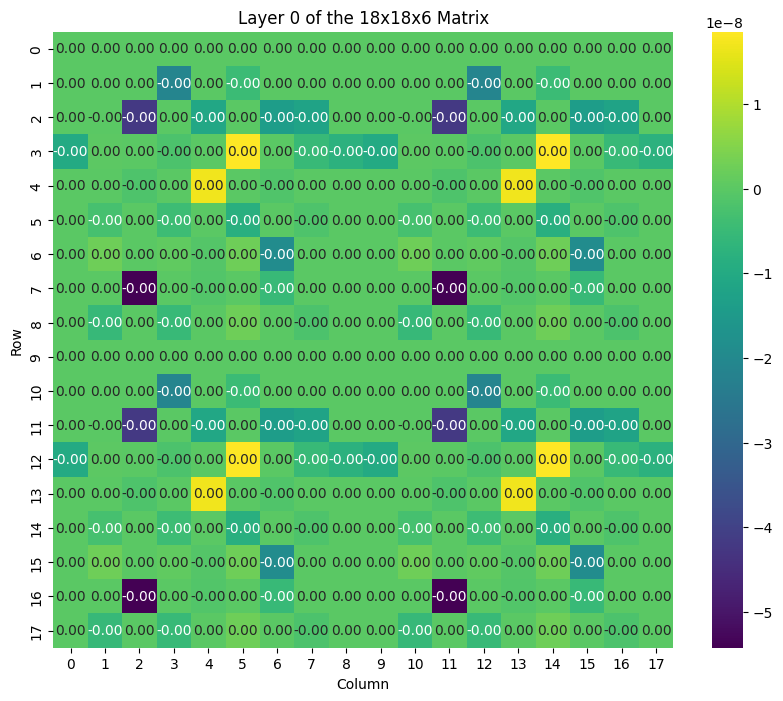

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

input_mat = segment_df['input_matrix'][0]

# Choose the layer to plot, e.g., layer 0
layer = 0
matrix_layer = input_mat[:, :, layer]

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(matrix_layer, annot=True, fmt=".2f", cmap="viridis", cbar=True)
plt.title(f"Layer {layer} of the 18x18x6 Matrix")
plt.xlabel("Column")
plt.ylabel("Row")
plt.show()

In [109]:
input_mat[:,:,0].shape

(18, 18)

32 from each quadrant

In [110]:
np.count_nonzero(input_mat[:,:,0])

128